In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM,Conv3D

In [2]:
def data_handler(name):
    dataframe =pd.read_csv(name)
    dataframe['datetime'] = dataframe['year'].map(str) + '-' + dataframe['month'].map(str) + '-' + dataframe['day'].map(str)
    dataframe['datetime'] = pd.to_datetime(dataframe['datetime'])
    dataframe['datetime'] = dataframe['datetime'] + dataframe['hour'].apply(lambda x: np.timedelta64(x, 'h'))
    dataframe.set_index('datetime',inplace=True)
    dataframe.pop('TEMP')
    dataframe.pop('PRES')
    dataframe.pop('DEWP')
    dataframe.pop('RAIN')
    dataframe.pop('WSPM')
    dataframe.pop('No')
    dataframe.pop('year')
    dataframe.pop('month')
    dataframe.pop('day')
    dataframe.pop('wd')
    dataframe.pop('O3')
    dataframe.pop('hour')



    dataframe.pop('station')
    dataframe=dataframe.interpolate(methode='time')
   
    dataframe=dataframe.resample('D').mean()

    df = np.asarray(dataframe)
    return dataframe


In [3]:
X1=data_handler("PRSA_Data_Aotizhongxin_20130301-20170228.csv")

In [4]:
Channels1=X1.diff()
Channels1=Channels1.dropna()
Channels2=X1.diff(365)
Channels1=Channels1[364:]
Channels2=Channels2.dropna()

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X1)
ch1 = scaler.transform(Channels1)


In [6]:

ch3 = scaler.transform(Channels2)

In [7]:

ch2 = scaler.transform(X1[365:])

In [8]:
def to_supervised(data,dropNa = True,lag=12):
    df = pd.DataFrame(data)
    column = []
    column.append(df)
    for i in range(1,13):
        column.append(df.shift(-i))
    df = pd.concat(column,axis=1)
    df.dropna(inplace = True)
    features = 5
    df = df.values
    supervised_data = df[:,:5*12]

    return supervised_data

In [9]:
timeSteps = 12
supervised1 = to_supervised(pd.DataFrame(ch1),timeSteps)


In [10]:
# spiltting the data
# training on only first year data
features = 5
train_hours = 900
X = supervised1[:,:(features*timeSteps)]

x_train1 = X[:train_hours,:]
x_test1 = X[train_hours:len(X)-timeSteps,:]

print (x_train1.shape,x_test1.shape)

(900, 60) (172, 60)


In [11]:
supervised2 = to_supervised(pd.DataFrame(ch2),timeSteps)

In [12]:
# spiltting the data
# training on only first year data
features = 5
train_hours = 900
X = supervised2[:,:(features*timeSteps)]

x_train2 = X[:train_hours,:]
x_test2 = X[train_hours:len(X)-timeSteps,:]

print (x_train2.shape,x_test2.shape)

(900, 60) (172, 60)


In [13]:
supervised3 = to_supervised(pd.DataFrame(ch3),timeSteps)
features = 5
train_hours = 900
X = supervised3[:,:(features*timeSteps)]
print(X.shape)
x_train3 = X[:train_hours,:]
x_test3 = X[train_hours:len(X)-timeSteps,:]

print (x_train3.shape,x_test3.shape)

(1084, 60)
(900, 60) (172, 60)


In [14]:
X_train1 = x_train1.reshape(x_train1.shape[0], timeSteps, features)
X_test1 = x_test1.reshape(x_test1.shape[0], timeSteps, features)

In [15]:
X_train2 = x_train2.reshape(x_train2.shape[0], timeSteps, features)
X_test2 = x_test2.reshape(x_test2.shape[0], timeSteps, features)

In [16]:
X_train3 = x_train3.reshape(x_train3.shape[0], timeSteps, features)
X_test3 = x_test3.reshape(x_test3.shape[0], timeSteps, features)

In [17]:
import tensorflow as tf

In [18]:
train_data=tf.convert_to_tensor((X_train1,X_train2,X_train3))

In [19]:
test_data=tf.convert_to_tensor((X_test1,X_test2,X_test3))

In [20]:
y = X1[377:]
y=scaler.transform(y)

In [21]:
y=y[:,0]

In [22]:
y_train = y[:train_hours]
y_test = y[train_hours:len(y)-timeSteps]

In [23]:
train_data=tf.transpose(train_data,[1,2,3,0])
test_data=tf.transpose(test_data,[1,2,3,0])

In [24]:
train_data=train_data[:,:,0,:]
test_data=test_data[:,:,0,:]

In [25]:
train_data.shape

TensorShape([900, 12, 3])

In [26]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling1D, LSTM,Conv3D,Conv1D,TimeDistributed

In [27]:
first_channel = tf.keras.Input(shape=(12,3))






X1=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150,  return_sequences=False))(first_channel)
X2=Dropout(0.4)(X1)





X11=Dense(1)(X2)

In [28]:
model=tf.keras.Model(first_channel,X11)

model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 3)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 300)              184800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
Total params: 185,101
Trainable params: 185,101
Non-trainable params: 0
_________________________________________________________________


In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, restore_best_weights=True)

with tf.device('/GPU:0'):
    history = model.fit(train_data,y_train, validation_data=(test_data,y_test),epochs=2000, shuffle=False,callbacks=[ early_stopping])

Epoch 1/2000
29/29 [==============================] - 12s 123ms/step - loss: 0.0182 - val_loss: 0.0247
Epoch 2/2000
29/29 [==============================] - 1s 42ms/step - loss: 0.0142 - val_loss: 0.0228
Epoch 3/2000
29/29 [==============================] - 1s 43ms/step - loss: 0.0133 - val_loss: 0.0219
Epoch 4/2000
29/29 [==============================] - 1s 33ms/step - loss: 0.0126 - val_loss: 0.0213
Epoch 5/2000
29/29 [==============================] - 1s 33ms/step - loss: 0.0126 - val_loss: 0.0210
Epoch 6/2000
29/29 [==============================] - 1s 32ms/step - loss: 0.0122 - val_loss: 0.0207
Epoch 7/2000
29/29 [==============================] - 1s 31ms/step - loss: 0.0118 - val_loss: 0.0206
Epoch 8/2000
29/29 [==============================] - 1s 33ms/step - loss: 0.0118 - val_loss: 0.0208
Epoch 9/2000
29/29 [==============================] - 1s 32ms/step - loss: 0.0116 - val_loss: 0.0208
Epoch 10/2000
29/29 [==============================] - 1s 34ms/step - loss: 0.0119 - val_

In [30]:
model.evaluate(test_data,y_test)

6/6 [==============================] - 0s 12ms/step - loss: 0.0205


0.020459813997149467

In [33]:
prediction=model.predict(test_data)

6/6 [==============================] - 2s 11ms/step


In [36]:
X=X1['PM2.5']


In [37]:
X=np.asarray(X).reshape((X.shape[0],1))

In [38]:
scaler2 = MinMaxScaler()
scaler2.fit(X)



MinMaxScaler()

In [39]:
df_predi=pd.DataFrame(y_test)

rev_trans=scaler2.inverse_transform(df_predi)

df_final=pd.DataFrame(rev_trans)

In [40]:

rev_trans1=scaler2.inverse_transform(prediction)




In [41]:
df_final[["PM2.5_pred"]]=rev_trans1

In [42]:
df_final

,0,PM2.5_pred
0,17.625000,29.291950
1,31.166667,33.429329
2,17.437500,41.328266
3,6.166667,28.491341
4,11.833333,24.327038
...,...,...
167,104.458333,49.714046
168,92.916667,97.835922
169,182.833333,78.276566
170,227.625000,143.166275


In [43]:
df_final.head(30)

,0,PM2.5_pred
0,17.625000,29.291950
1,31.166667,33.429329
2,17.437500,41.328266
3,6.166667,28.491341
4,11.833333,24.327038
5,18.458333,30.085270
6,79.833333,32.132858
7,27.000000,74.771927
8,21.742188,28.545895
9,42.820312,30.429638


<AxesSubplot:>

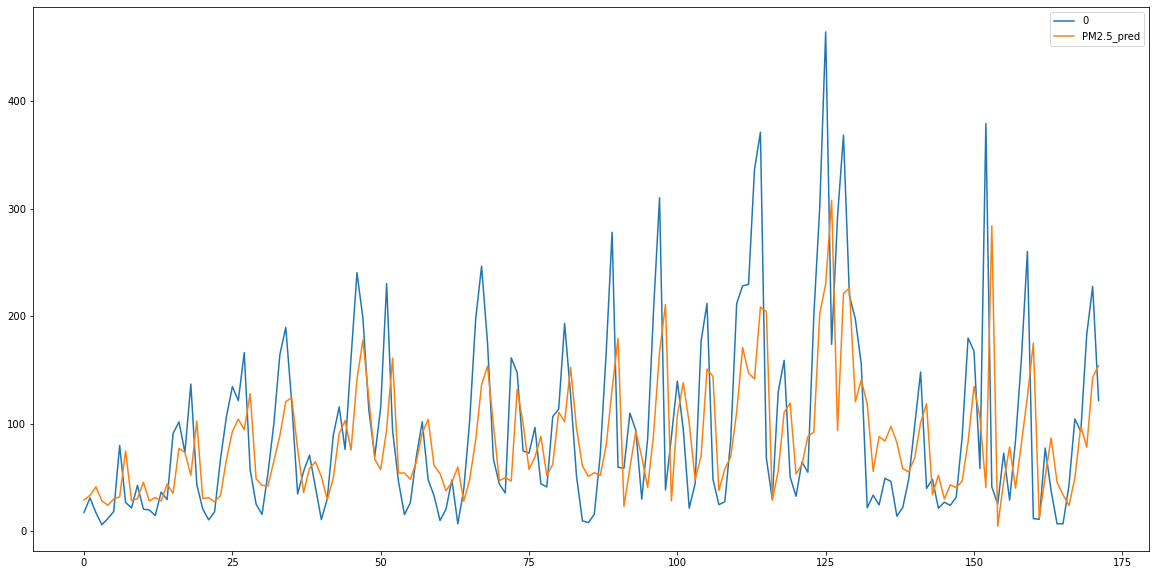

In [44]:
df_final[[0,"PM2.5_pred"]].plot(figsize=(20,10))

In [45]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
# calculate root mean squared error
testScore = math.sqrt(mean_squared_error(df_final[0], df_final["PM2.5_pred"]))
print('Test Score: %.2f RMSE' % (testScore))
#calculate mean aboslute error
mae=mean_absolute_error(df_final[0],df_final["PM2.5_pred"])
print('\nMae Score: %.2f ' % (mae))


Test Score: 72.99 RMSE

Mae Score: 51.67 


In [46]:
test_series = df_final[0]
# state of model performance
if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))


[ Model performance is GOOD enough ]

RMSE of test prediction < Standard deviation of test dataset
72.99 < 87.31


Text(0, 0.5, 'mse score')

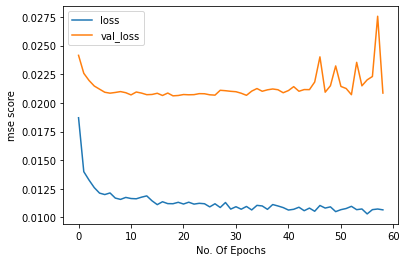

In [47]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

In [48]:
model.save('./modelbilstuni-Uni')

INFO:tensorflow:Assets written to: ./modelbilstuni-Uni\assets


INFO:tensorflow:Assets written to: ./modelbilstuni-Uni\assets
